In [1]:
%matplotlib inline

from strip_catalogue import get_raw_course_list, get_quarter_offerings, iterate_plan
from scrapercleaner import clean_scrape
import networkx as nx
import re
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
def get_avg_num_prereqs(courses, undergrad=False):
    """
    Gets average number of prereqs for given courses, optionally only for undergrad.
    Input should be same format as clean_scrape().
    :param courses: list of courses, same as output of clean_scrape()
    :type courses: list or tuple
    :param undergrad: whether only undergrad should be considered
    :type undergrad: true
    :return: int
    """
    assert isinstance(courses, list) or isinstance(courses, tuple)
    assert isinstance(undergrad, bool)
    sum = 0
    count = 0
    for (course, prereqs) in courses:
        if undergrad:
            num = re.findall('\d+', course)[0]
            if int(num) >= 200:
                continue
        if prereqs:
            sum += len(prereqs)
            count += 1
    return sum/count

In [3]:
def generate_graph(dept, courses, undergrad=False):
    """
    Generates a graph for testing, based on a list of courses (see scrapercleaner.clean_scrape() for format).
    :param dept: department name
    :type dept: str
    :param courses: list of courses from clean_scrape()
    :type courses: list or tuple
    :param undergrad: whether only undergrad should be considered
    :type undergrad: true
    :return: networkx.DiGraph
    """
    assert isinstance(dept, str)
    assert isinstance(courses, list) or isinstance(courses, tuple)
    assert isinstance(undergrad, bool)

    indep_courses = []
    prereqs = []
    for course in courses:
        k, v = course
        # remove grad classes
        if undergrad:
            num = re.findall('\d+', k)[0]
            if int(num) >= 200:
                continue
        if v:
            for i in v:
                weight = len(i)
                for j in i:
                    if j.startswith(dept):
                        prereqs.append([j.split()[1].lstrip("0"), k, 1/weight])
        # if no prereqs, add as independent node
        else:
            indep_courses.append(k.lstrip("0"))

    G = nx.DiGraph()
    G.add_nodes_from(indep_courses)
    G.add_weighted_edges_from(prereqs)
    return G

In [4]:
def find_root(G, child):
    """
    Find the root of any given node.
    :param G: graph to search
    :type G: networkx.DiGraph
    :param child: child node to find root
    :type child: str
    :return: str
    """
    assert isinstance(G, nx.classes.digraph.DiGraph)
    assert isinstance(child, str)

    parent = list(G.predecessors(child))
    if len(parent) == 0:
        return child
    else:
        return find_root(G, parent[0])

def get_flexibility(G):
    """
    Computes the number of paths between each end node and all root nodes and divides by total number of nodes.
    :param G: graph to analyze
    :type G: networkx.DiGraph
    :return: float
    """
    assert isinstance(G, nx.classes.digraph.DiGraph)

    heads = set()
    for i in G.nodes:
        r = find_root(G, i)
        if r != i:
            heads.add(r)
    tails = [n for n in G.nodes() if G.out_degree(n) == 0]
    sum = 0
    for h in heads:
        for t in tails:
            sum += len(list(nx.all_simple_paths(G,h,t)))
    return sum/G.number_of_nodes()

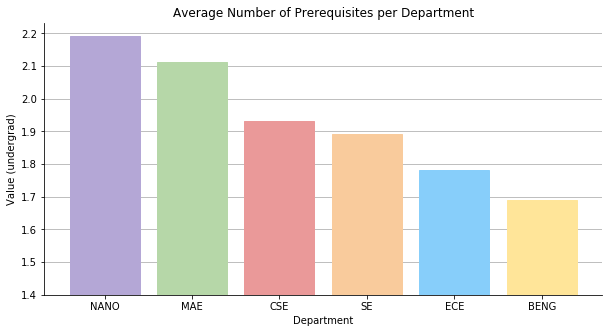

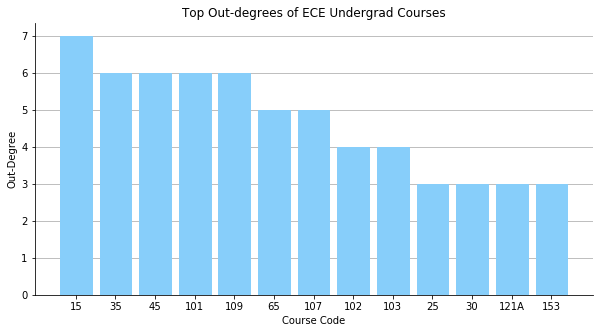

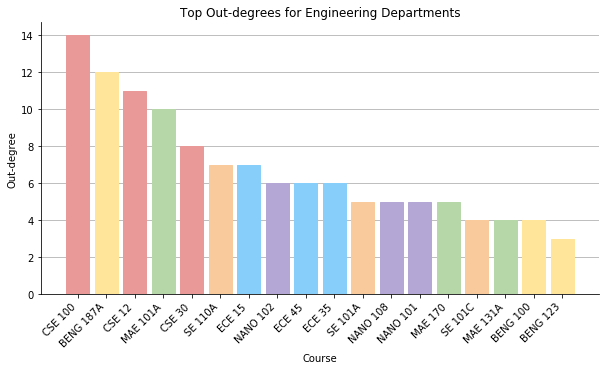

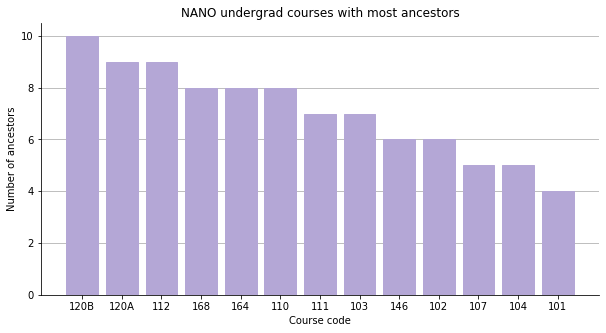

In [5]:
depts = ['ECE', 'CSE', 'MAE', 'BENG', 'NANO', 'SE']
colors = {'CSE': '#ea9999', 'ECE': '#87cefa', 'MAE': '#b6d7a8', 'NANO': '#b4a7d6', 'SE': '#f9cb9c', 'BENG': '#ffe599'}
avg_prereqs = []
out_degrees = []
ece_out = []
top_ancestors = []
flex = []
for dept in depts:
    raw_courses = get_raw_course_list(dept)
    courses = clean_scrape(raw_courses)
    avg = get_avg_num_prereqs(courses, True)
    avg_prereqs.append([avg, dept])

    G = generate_graph(dept, courses, True)
    out_deg = list(G.out_degree)
    out_deg.sort(key=lambda i: i[1], reverse=True)
    # get top 3 out degrees per major
    for i in range(3):
        out_degrees.append([out_deg[i][1], dept + ' ' + out_deg[i][0]])
    # get top 13 ECE out degrees
    if dept == 'ECE':
        for i in range(13):
            ece_out.append([out_deg[i][1], out_deg[i][0]])

    # get highest ancestor count courses from NANO
    for n in G.nodes():
        if dept == 'NANO':
            top_ancestors.append([len(nx.algorithms.dag.ancestors(G, n)), n])
    flex.append([get_flexibility(G),dept])

plt.rc('axes', axisbelow=True)
figsize=(10,5)
avg_prereqs.sort(reverse=True)
plt.figure(figsize=figsize)
avg_bar = plt.bar([i[1] for i in avg_prereqs], [i[0]-1.4 for i in avg_prereqs],bottom=1.4)
plt.title('Average Number of Prerequisites per Department')
plt.xlabel('Department')
plt.ylabel('Value (undergrad)')
plt.grid(True, 'major', 'y')
for i, bar in enumerate(avg_bar):
    bar.set_color(colors[avg_prereqs[i][1]])

plt.figure(figsize=figsize)
e_out_bar = plt.bar([i[1] for i in ece_out], [i[0] for i in ece_out])
plt.title('Top Out-degrees of ECE Undergrad Courses')
plt.xlabel('Course Code')
plt.ylabel('Out-Degree')
plt.grid(True, 'major', 'y')
for i, bar in enumerate(e_out_bar):
    bar.set_color(colors['ECE'])    

out_degrees.sort(reverse=True)
plt.figure(figsize=figsize)
out_bar = plt.bar([i[1] for i in out_degrees], [i[0] for i in out_degrees])
plt.title('Top Out-degrees for Engineering Departments')
plt.xlabel('Course')
plt.ylabel('Out-degree')
plt.grid(True, 'major', 'y')
plt.xticks(rotation=45, ha='right')
for i, bar in enumerate(out_bar):
    bar.set_color(colors[out_degrees[i][1].split()[0]])
    
top_ancestors.sort(reverse=True)
plt.figure(figsize=figsize)
top_ancestors = top_ancestors[:13]
anc_bar = plt.bar([i[1] for i in top_ancestors], [i[0] for i in top_ancestors])
plt.title('NANO undergrad courses with most ancestors')
plt.xlabel('Course code')
plt.ylabel('Number of ancestors')
plt.grid(True, 'major', 'y')
for i, bar in enumerate(anc_bar):
    bar.set_color(colors['NANO'])

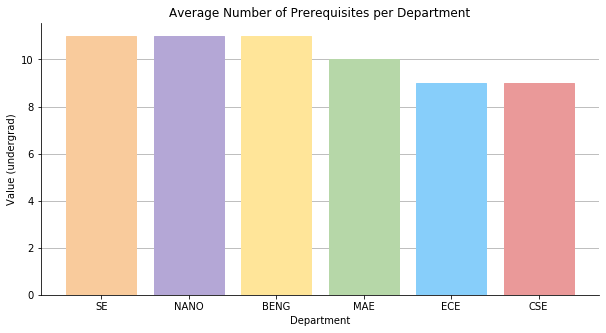

In [6]:
# example course plans based on each major's requirements
plans = dict()
plans['ECE'] = ['ECE 5', 'ECE 25', 'ECE 30', 'ECE 35', 'ECE 45', 'ECE 65', 'ECE 15', 'ECE 17', 'MATH 18', 'MATH 20A', \
              'MATH 20B', 'MATH 20C', 'MATH 20D', 'MATH 20E', 'CHEM 6A', 'PHYS 2A', 'PHYS 2B', 'PHYS 2C', 'ECE 100', \
              'ECE 101', 'ECE 107', 'ECE 109', 'ECE 171A', 'ECE 174', 'ECE 175A', 'ECE 171B', 'ECE 111', 'ECE 153', \
              'ECE 161A', 'ECE 161B', 'ECE 161C', 'ECE 164', 'ECE 143', 'ECE 158A', 'ECE 158B', 'ECE 16', 'ECE 102']
plans['CSE'] = ['CSE 8B', 'CSE 12', 'CSE 15L', 'CSE 20', 'CSE 21', 'CSE 30', 'CSE 3', 'CSE 7', 'MATH 20A', 'MATH 20B', \
              'MATH 20C', 'MATH 18', 'PHYS 2A', 'PHYS 2B', 'CSE 103', 'CSE 100', 'CSE 101', 'CSE 105', 'CSE 110', \
              'CSE 140', 'CSE 141', 'CSE 120', 'CSE 130', 'CSE 107', 'CSE 150A', 'ECE 174', 'ECE 153', 'CSE 151', \
              'CSE 152', 'CSE 154', 'CSE 156', 'CSE 166']
plans['NANO'] = ['MATH 18', 'MATH 20A', 'MATH 20B', 'MATH 20C','MATH 20D', 'MATH 20E', 'PHYS 2A', 'PHYS 2B', 'PHYS 2C', \
               'PHYS 2D', 'CHEM 6A', 'CHEM 6B', 'CHEM 6C', 'NANO 15', 'NANO 106', 'NANO 107', 'NANO 1', 'NANO 101', \
               'NANO 102', 'NANO 103', 'NANO 104', 'NANO 110', 'NANO 111', 'NANO 112', 'NANO 120A', 'NANO 120B', \
               'NANO 141A', 'NANO 141B', 'NANO 108', 'NANO 148', 'NANO 158', 'NANO 174', 'NANO 168']
plans['SE'] = ['MATH 20A', 'MATH 20B', 'MATH 20C', 'SE 1', 'SE 3', 'CHEM 6A', 'PHYS 2A', 'PHYS 2B', 'MATH 20D', 'MATH 18', \
             'MATH 20E', 'SE 101A', 'SE 101B', 'SE 9', 'PHYS 2C', 'SE 110A', 'SE 110B', 'SE 104', 'SE 101C', 'SE 115', \
             'SE 131', 'SE 121A', 'SE 121B', 'SE 130B', 'SE 130A', 'SE 125', 'SE 140A', 'SE 140B', 'SE 167', 'SE 168', \
             'SE 163', 'SE 160A', 'SE 160B']
plans['MAE'] = ['MATH 20B', 'MATH 20C', 'PHYS 2A', 'PHYS 2B', 'MAE 3', 'MATH 18', 'MATH 20E', 'MAE 8', 'MAE 30A', 'MAE 30B' \
              'MAE 131A', 'MAE 101A', 'MAE 101B', 'MAE 143A', 'MAE 143B', 'MAE 170', 'MAE 160', 'MAE 171A', 'MAE 156B', \
              'MAE 156A', 'MATH 20A', 'CHEM 6A', 'MATH 20D', 'PHYS 2C', 'ESYS 101', 'MAE 3', 'CENG 100', 'MAE 105', \
              'MAE 107', 'CHEM 171', 'MAE 101C', 'MAE 150', 'MAE 122', 'ECE 174', 'MAE 120', 'ECE 143', 'MAE 130']
plans['BENG'] = ['BENG 1', 'BILD 1', 'CHEM 6A', 'CHEM 6B', 'MAE 8', 'MATH 20A', 'MATH 20B', 'MATH 20C', 'PHYS 2A', \
               'PHYS 2B', 'PHYS 2BL', 'BENG 100', 'BENG 109', 'CHEM 7L', 'MAE 3', 'MAE 140', 'MATH 20D', 'MATH 20E', \
               'MATH 20F', 'PHYS 2C', 'PHYS 2CL', 'BENG 101', 'BENG 103B', 'BENG 110', 'BENG 112A', 'BENG 140A', \
               'BENG 140B', 'BENG 172', 'BENG 186B', 'BENG 187A', 'BENG 191', 'MAE 170', 'BENG 122A', 'BENG 125', \
               'BENG 130', 'BENG 186A', 'BENG 187B', 'BENG 187C', 'BENG 187D', 'BENG 169A', 'BENG 169B', 'BENG 191', \
               'MAE 107', 'MAE 150', 'ECE 171', 'ECE 174']

plan_res = []
for k, v in plans.items():
    plan_res.append([len(iterate_plan(v, 5, 1, 100)), k])

plan_res.sort(reverse=True)
plt.figure(figsize=figsize)
plan_bar = plt.bar([i[1] for i in plan_res], [i[0] for i in plan_res])
plt.title('Average Number of Prerequisites per Department')
plt.xlabel('Department')
plt.ylabel('Value (undergrad)')
plt.grid(True, 'major', 'y')
for i, bar in enumerate(plan_bar):
    bar.set_color(colors[plan_res[i][1]])

## Drawing example directed graphs

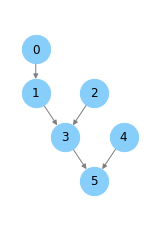

In [7]:
D = nx.DiGraph()
D.add_edge(0,1)
D.add_edge(1,3)
D.add_edge(2,3)
D.add_edge(4,5)
D.add_edge(3,5)
#D.add_edge(45,100)
#D.add_edge(65,100)
#D = nx.generators.directed.gnr_graph(15, 0.3).reverse()

pos = graphviz_layout(D, prog='dot')
scale = 1
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw_networkx(D, pos, arrows=True, with_labels=True, node_size=scale*800, font_size=12, node_color='LightSkyBlue', edge_color=(0.5,0.5,0.5))
plt.axis('off')
# tweak these values to compress the image
plt.margins(x=.25, y=.25)
ax.set_aspect(0.75)
plt.show()

## For the website visualization, see `dash_viz.py` and run it (or go to https://ece143-group8.herokuapp.com/)
Heroku app is using free dynos, so it shuts down after 30 min of inactivity and takes a while to restart

Dash interactivity cannot be done in a notebook, so it needs to be run as a standalone server